In [41]:
import os
import re
import pickle
from pathlib import Path
import yaml
import json

import anndata
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import scanpy.external as sce
import pandas as pd
import torch
import tifffile
from einops import rearrange, repeat

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [36]:
import mushroom.utils as utils
import mushroom.registration.bigwarp as bigwarp

In [22]:
project_dir = Path('/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1')

In [27]:
case_order = [
    'HT206B1',
#     'HT268B1',
    'HT339B2-H1',
    'HT397B1',
    'HT565B1-H2',
    'HT704B1',
    'HT891Z1',
    'HT913Z1',
    'S18-5591-C8',
    'S18-9906',
]

In [52]:
fps = sorted(utils.listfiles('/diskmnt/Projects/Users/estorrs/imaging-analysis/results/serial_sections/cell_typed/',
                     regex=r'cell_typed.h5ad'))
fps

['/diskmnt/Projects/Users/estorrs/imaging-analysis/results/serial_sections/cell_typed/HT206B1_cell_typed.h5ad',
 '/diskmnt/Projects/Users/estorrs/imaging-analysis/results/serial_sections/cell_typed/HT339B2-H1_cell_typed.h5ad',
 '/diskmnt/Projects/Users/estorrs/imaging-analysis/results/serial_sections/cell_typed/HT397B1_cell_typed.h5ad',
 '/diskmnt/Projects/Users/estorrs/imaging-analysis/results/serial_sections/cell_typed/HT565B1-H2_cell_typed.h5ad',
 '/diskmnt/Projects/Users/estorrs/imaging-analysis/results/serial_sections/cell_typed/HT704B1_cell_typed.h5ad',
 '/diskmnt/Projects/Users/estorrs/imaging-analysis/results/serial_sections/cell_typed/HT891Z1_cell_typed.h5ad',
 '/diskmnt/Projects/Users/estorrs/imaging-analysis/results/serial_sections/cell_typed/HT913Z1_cell_typed.h5ad',
 '/diskmnt/Projects/Users/estorrs/imaging-analysis/results/serial_sections/cell_typed/S18-5591-C8_cell_typed.h5ad',
 '/diskmnt/Projects/Users/estorrs/imaging-analysis/results/serial_sections/cell_typed/S18-9906

In [88]:
sid_mapping = {
    'HT206B1-H2L1-U10': 'HT206B1-U10',
    'HT206B1-H2L1-U13': 'HT206B1-U13',
    'HT206B1-H2L1-U18': 'HT206B1-U18',
    'HT206B1-H2L1-U2': 'HT206B1-U2',
    'HT206B1-H2L1-U21': 'HT206B1-U21',
    'HT206B1-H2L1-U5': 'HT206B1-U5',
    'HT339B2-H1': 'HT339B2-H1-U2',
    'HT397B1-S1H3A1-U2': 'HT397B1-U2',
    'HT397B1-S1H3A1-U12': 'HT397B1-U12',
    'HT397B1-S1H3A1-U22': 'HT397B1-U22',
    'HT397B1-S1H3A1-U31': 'HT397B1-U31',
    'HT565B1-H2': 'HT565B1-H2-U2',
}

def remap_sid(sid):
    sid = sid_mapping.get(sid, sid)
    
    if 'HT704B1' in sid:
        sid = sid.replace('_', '-')
        
    if 'HT891Z1' in sid:
        sid = sid.replace('-S2H3Fp1_', '-')
        if sid.split('-')[-1] == 'U31':
            sid = 'HT891Z1-U32'
    
    if 'HT913Z1' in sid:
        sid = sid.replace('-S2H1FP1_', '-')
    
    if 'S18-5591' in sid:
        pieces = sid.split('-')
        pieces.insert(2, 'C8')
        sid = '-'.join(pieces)

    
    return sid

In [71]:
# a = sc.read_h5ad('/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT565B1-H2/registered/s0_HT565B1-H2-U1_visium.h5ad')
# a.uns['ppm']

In [67]:
# for samples not originallyr egistered to 1 mpp
case_to_downscale = {
    'HT339B2-H1': 0.35026268395892945,
    'HT397B1': 0.36435700315543124,
    'HT565B1-H2': 0.3414196499351769
}

HT206B1 (576826, 39)
HT206B1-U2
HT206B1-U5
HT206B1-U10
HT206B1-U13
HT206B1-U18
HT206B1-U21
dict_keys(['HT206B1-U2', 'HT206B1-U5', 'HT206B1-U10', 'HT206B1-U13', 'HT206B1-U18', 'HT206B1-U21'])
HT206B1-H2L1-U10 (100948, 39)


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_146382/3959162083.py:44: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f.obs['row'] = warped[:, 0]
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

HT206B1-H2L1-U13 (96767, 39)


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_146382/3959162083.py:44: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f.obs['row'] = warped[:, 0]
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


HT206B1-H2L1-U18 (99718, 39)


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_146382/3959162083.py:44: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f.obs['row'] = warped[:, 0]
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


HT206B1-H2L1-U2 (95534, 39)


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_146382/3959162083.py:44: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f.obs['row'] = warped[:, 0]
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


HT206B1-H2L1-U21 (93989, 39)


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_146382/3959162083.py:44: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f.obs['row'] = warped[:, 0]
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


HT206B1-H2L1-U5 (89870, 39)


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_146382/3959162083.py:44: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f.obs['row'] = warped[:, 0]
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/merge.py:217: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(dtype):
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:315: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

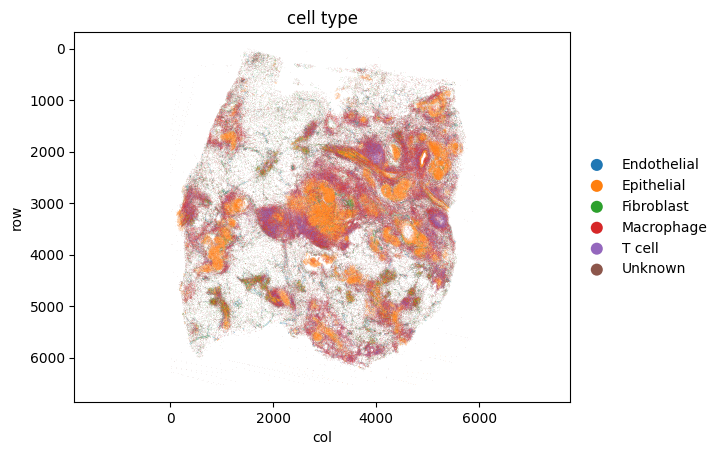

HT339B2-H1 (38822, 33)
HT339B2-H1-U2
dict_keys(['HT339B2-H1-U2'])
HT339B2-H1 (38822, 33)


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_146382/3959162083.py:44: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f.obs['row'] = warped[:, 0]
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/merge.py:217: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future

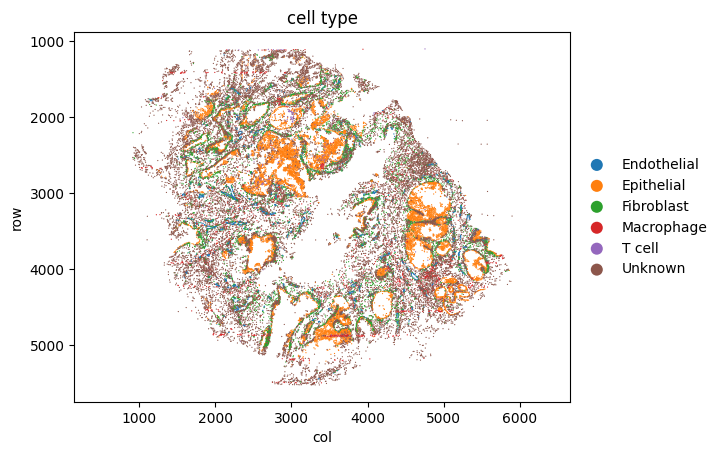

HT397B1 (657740, 28)
HT397B1-U2
HT397B1-U12
HT397B1-U22
HT397B1-U31
dict_keys(['HT397B1-U2', 'HT397B1-U12', 'HT397B1-U22', 'HT397B1-U31'])
HT397B1-S1H3A1-U12 (182286, 28)


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_146382/3959162083.py:44: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f.obs['row'] = warped[:, 0]
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

HT397B1-S1H3A1-U2 (203462, 28)


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_146382/3959162083.py:44: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f.obs['row'] = warped[:, 0]
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


HT397B1-S1H3A1-U22 (154367, 28)


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_146382/3959162083.py:44: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f.obs['row'] = warped[:, 0]
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


HT397B1-S1H3A1-U31 (117625, 28)


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_146382/3959162083.py:44: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f.obs['row'] = warped[:, 0]
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/merge.py:217: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(dtype):
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:315: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

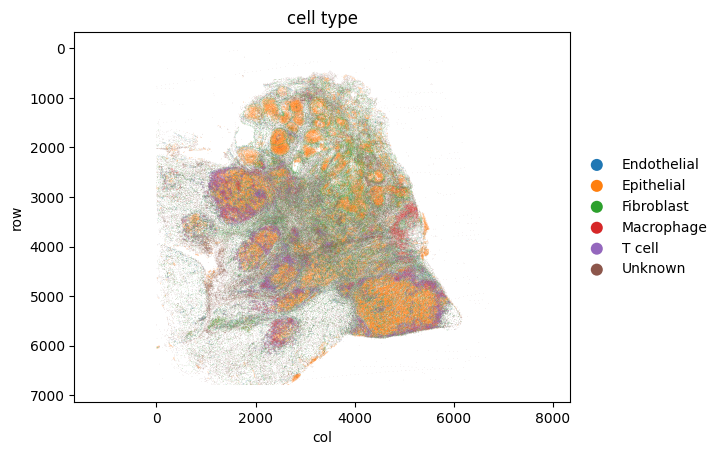

HT565B1-H2 (68677, 33)
HT565B1-H2-U2
dict_keys(['HT565B1-H2-U2'])
HT565B1-H2 (68677, 33)


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_146382/3959162083.py:44: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f.obs['row'] = warped[:, 0]
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/merge.py:217: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future

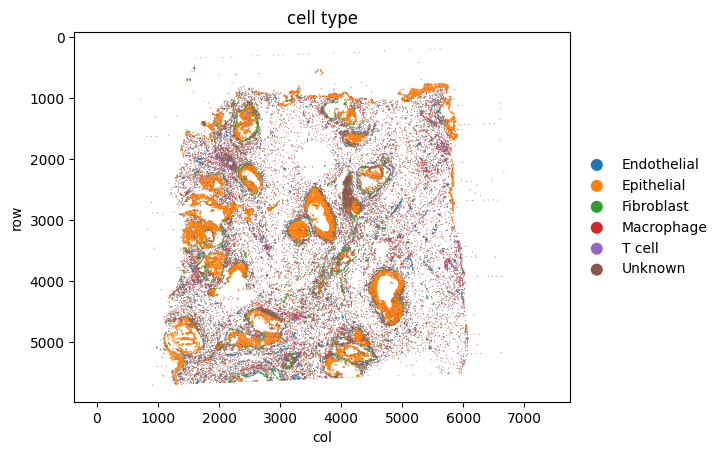

HT704B1 (1567850, 38)
HT704B1-U11
HT704B1-U19
HT704B1-U27
HT704B1-U35
HT704B1-U43
HT704B1-U53
HT704B1-U60
HT704B1-U68
HT704B1-U76
HT704B1-U82
HT704B1-U85
HT704B1-U91
dict_keys(['HT704B1-U11', 'HT704B1-U19', 'HT704B1-U27', 'HT704B1-U35', 'HT704B1-U43', 'HT704B1-U53', 'HT704B1-U60', 'HT704B1-U68', 'HT704B1-U76', 'HT704B1-U82', 'HT704B1-U85', 'HT704B1-U91'])


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


HT704B1_U11 (176642, 38)


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_146382/3959162083.py:44: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f.obs['row'] = warped[:, 0]
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


HT704B1_U19 (172128, 38)


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_146382/3959162083.py:44: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f.obs['row'] = warped[:, 0]
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


HT704B1_U27 (187758, 38)


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_146382/3959162083.py:44: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f.obs['row'] = warped[:, 0]
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


HT704B1_U35 (171510, 38)


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_146382/3959162083.py:44: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f.obs['row'] = warped[:, 0]
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


HT704B1_U43 (163127, 38)


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_146382/3959162083.py:44: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f.obs['row'] = warped[:, 0]
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


HT704B1_U53 (143164, 38)


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_146382/3959162083.py:44: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f.obs['row'] = warped[:, 0]
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


HT704B1_U60 (81315, 38)


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_146382/3959162083.py:44: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f.obs['row'] = warped[:, 0]
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


HT704B1_U68 (132602, 38)


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_146382/3959162083.py:44: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f.obs['row'] = warped[:, 0]
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


HT704B1_U76 (103959, 38)


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_146382/3959162083.py:44: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f.obs['row'] = warped[:, 0]
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


HT704B1_U82 (90632, 38)


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_146382/3959162083.py:44: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f.obs['row'] = warped[:, 0]
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


HT704B1_U85 (82110, 38)


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_146382/3959162083.py:44: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f.obs['row'] = warped[:, 0]
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


HT704B1_U91 (62903, 38)


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_146382/3959162083.py:44: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f.obs['row'] = warped[:, 0]
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/merge.py:217: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(dtype):
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:315: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

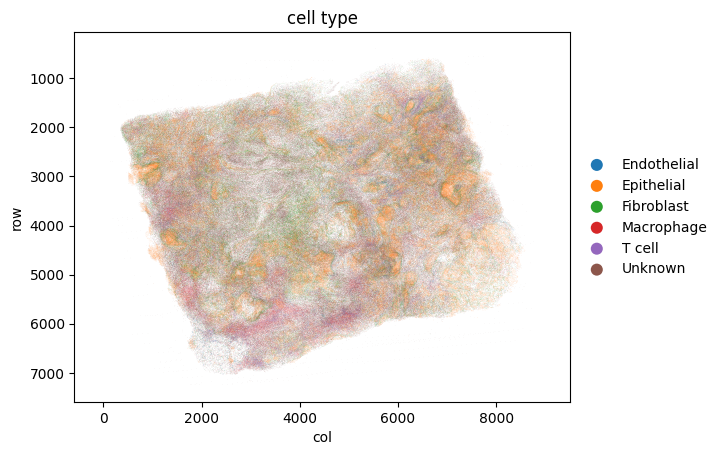

HT891Z1 (2511647, 25)
HT891Z1-U14
HT891Z1-U32
HT891Z1-U40
HT891Z1-U41
HT891Z1-U43
HT891Z1-U45
HT891Z1-U46
HT891Z1-U58
HT891Z1-U79
HT891Z1-U93
HT891Z1-U103
HT891Z1-U108
HT891Z1-U109
HT891Z1-U110
HT891Z1-U111
HT891Z1-U113
dict_keys(['HT891Z1-U14', 'HT891Z1-U32', 'HT891Z1-U40', 'HT891Z1-U41', 'HT891Z1-U43', 'HT891Z1-U45', 'HT891Z1-U46', 'HT891Z1-U58', 'HT891Z1-U79', 'HT891Z1-U93', 'HT891Z1-U103', 'HT891Z1-U108', 'HT891Z1-U109', 'HT891Z1-U110', 'HT891Z1-U111', 'HT891Z1-U113'])
HT891Z1-S2H3Fp1_U103 (117497, 25)


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_146382/3959162083.py:44: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f.obs['row'] = warped[:, 0]
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

HT891Z1-S2H3Fp1_U108 (97423, 25)


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_146382/3959162083.py:44: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f.obs['row'] = warped[:, 0]
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


HT891Z1-S2H3Fp1_U109 (74905, 25)


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_146382/3959162083.py:44: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f.obs['row'] = warped[:, 0]
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


HT891Z1-S2H3Fp1_U110 (91855, 25)


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_146382/3959162083.py:44: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f.obs['row'] = warped[:, 0]
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


HT891Z1-S2H3Fp1_U111 (81762, 25)


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_146382/3959162083.py:44: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f.obs['row'] = warped[:, 0]
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


HT891Z1-S2H3Fp1_U113 (83748, 25)


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_146382/3959162083.py:44: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f.obs['row'] = warped[:, 0]
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


HT891Z1-S2H3Fp1_U14 (215559, 25)


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_146382/3959162083.py:44: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f.obs['row'] = warped[:, 0]
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


HT891Z1-S2H3Fp1_U31 (205038, 25)


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_146382/3959162083.py:44: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f.obs['row'] = warped[:, 0]
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


HT891Z1-S2H3Fp1_U40 (202396, 25)


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_146382/3959162083.py:44: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f.obs['row'] = warped[:, 0]
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


HT891Z1-S2H3Fp1_U41 (203148, 25)


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_146382/3959162083.py:44: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f.obs['row'] = warped[:, 0]
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


HT891Z1-S2H3Fp1_U43 (204821, 25)


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_146382/3959162083.py:44: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f.obs['row'] = warped[:, 0]
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


HT891Z1-S2H3Fp1_U45 (201397, 25)


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_146382/3959162083.py:44: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f.obs['row'] = warped[:, 0]
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


HT891Z1-S2H3Fp1_U46 (205263, 25)


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_146382/3959162083.py:44: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f.obs['row'] = warped[:, 0]
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


HT891Z1-S2H3Fp1_U58 (206766, 25)


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_146382/3959162083.py:44: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f.obs['row'] = warped[:, 0]
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


HT891Z1-S2H3Fp1_U79 (173678, 25)


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_146382/3959162083.py:44: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f.obs['row'] = warped[:, 0]
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


HT891Z1-S2H3Fp1_U93 (146391, 25)


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_146382/3959162083.py:44: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f.obs['row'] = warped[:, 0]
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/merge.py:217: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(dtype):
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:315: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

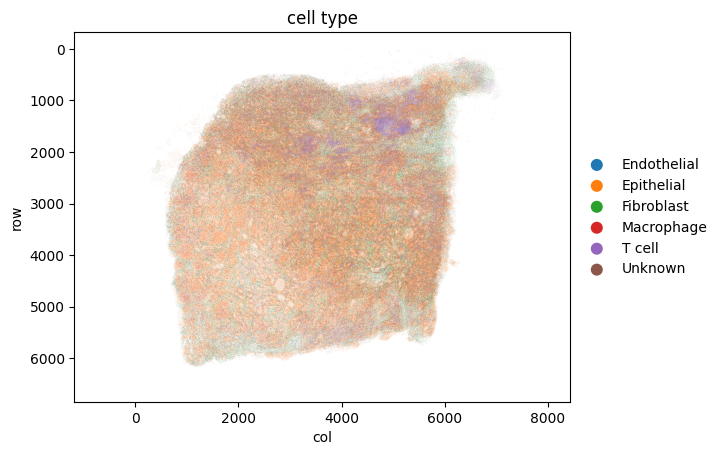

HT913Z1 (3681323, 25)
HT913Z1-U2
HT913Z1-U12
HT913Z1-U22
HT913Z1-U41
HT913Z1-U51
HT913Z1-U52
HT913Z1-U53
HT913Z1-U54
HT913Z1-U62
HT913Z1-U71
HT913Z1-U82
HT913Z1-U91
HT913Z1-U102
HT913Z1-U111
HT913Z1-U121
HT913Z1-U125
dict_keys(['HT913Z1-U2', 'HT913Z1-U12', 'HT913Z1-U22', 'HT913Z1-U41', 'HT913Z1-U51', 'HT913Z1-U52', 'HT913Z1-U53', 'HT913Z1-U54', 'HT913Z1-U62', 'HT913Z1-U71', 'HT913Z1-U82', 'HT913Z1-U91', 'HT913Z1-U102', 'HT913Z1-U111', 'HT913Z1-U121', 'HT913Z1-U125'])


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


HT913Z1-S2H1FP1_U102 (184777, 25)


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_146382/3959162083.py:44: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f.obs['row'] = warped[:, 0]
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


HT913Z1-S2H1FP1_U111 (155827, 25)


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_146382/3959162083.py:44: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f.obs['row'] = warped[:, 0]
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


HT913Z1-S2H1FP1_U12 (273617, 25)


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_146382/3959162083.py:44: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f.obs['row'] = warped[:, 0]
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


HT913Z1-S2H1FP1_U121 (124513, 25)


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_146382/3959162083.py:44: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f.obs['row'] = warped[:, 0]
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


HT913Z1-S2H1FP1_U125 (132019, 25)


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_146382/3959162083.py:44: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f.obs['row'] = warped[:, 0]
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


HT913Z1-S2H1FP1_U2 (266414, 25)


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_146382/3959162083.py:44: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f.obs['row'] = warped[:, 0]
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


HT913Z1-S2H1FP1_U22 (275188, 25)


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_146382/3959162083.py:44: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f.obs['row'] = warped[:, 0]
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


HT913Z1-S2H1FP1_U41 (268463, 25)


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_146382/3959162083.py:44: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f.obs['row'] = warped[:, 0]
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


HT913Z1-S2H1FP1_U51 (264581, 25)


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_146382/3959162083.py:44: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f.obs['row'] = warped[:, 0]
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


HT913Z1-S2H1FP1_U52 (261858, 25)


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_146382/3959162083.py:44: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f.obs['row'] = warped[:, 0]
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


HT913Z1-S2H1FP1_U53 (261167, 25)


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_146382/3959162083.py:44: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f.obs['row'] = warped[:, 0]
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


HT913Z1-S2H1FP1_U54 (260651, 25)


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_146382/3959162083.py:44: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f.obs['row'] = warped[:, 0]
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


HT913Z1-S2H1FP1_U62 (255293, 25)


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_146382/3959162083.py:44: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f.obs['row'] = warped[:, 0]
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


HT913Z1-S2H1FP1_U71 (248081, 25)


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_146382/3959162083.py:44: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f.obs['row'] = warped[:, 0]
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


HT913Z1-S2H1FP1_U82 (233875, 25)


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_146382/3959162083.py:44: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f.obs['row'] = warped[:, 0]
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


HT913Z1-S2H1FP1_U91 (214999, 25)


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_146382/3959162083.py:44: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f.obs['row'] = warped[:, 0]
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/merge.py:217: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(dtype):
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:315: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

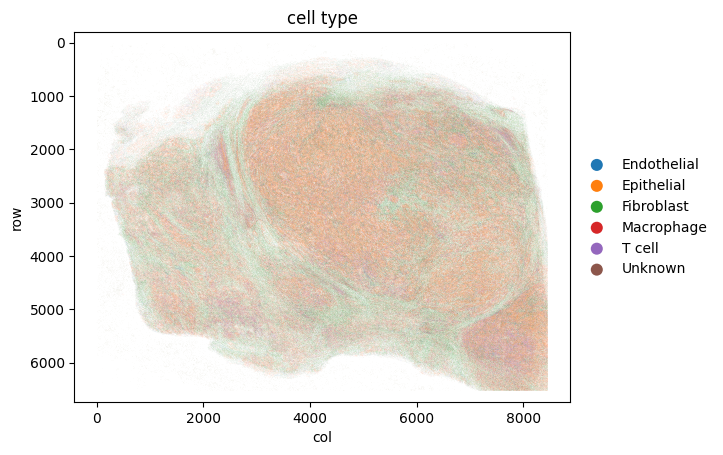

S18-5591-C8 (1710568, 24)
S18-5591-C8-U8
S18-5591-C8-U14
S18-5591-C8-U19
S18-5591-C8-U21
S18-5591-C8-U23
S18-5591-C8-U24
dict_keys(['S18-5591-C8-U8', 'S18-5591-C8-U14', 'S18-5591-C8-U19', 'S18-5591-C8-U21', 'S18-5591-C8-U23', 'S18-5591-C8-U24'])


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


S18-5591-U14 (257293, 24)


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_146382/3959162083.py:44: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f.obs['row'] = warped[:, 0]
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


S18-5591-U19 (257451, 24)


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_146382/3959162083.py:44: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f.obs['row'] = warped[:, 0]
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


S18-5591-U21 (242835, 24)


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_146382/3959162083.py:44: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f.obs['row'] = warped[:, 0]
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


S18-5591-U23 (277561, 24)


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_146382/3959162083.py:44: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f.obs['row'] = warped[:, 0]
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


S18-5591-U24 (262010, 24)


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_146382/3959162083.py:44: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f.obs['row'] = warped[:, 0]
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


S18-5591-U8 (247589, 24)


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_146382/3959162083.py:44: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f.obs['row'] = warped[:, 0]
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/merge.py:217: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(dtype):
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:315: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

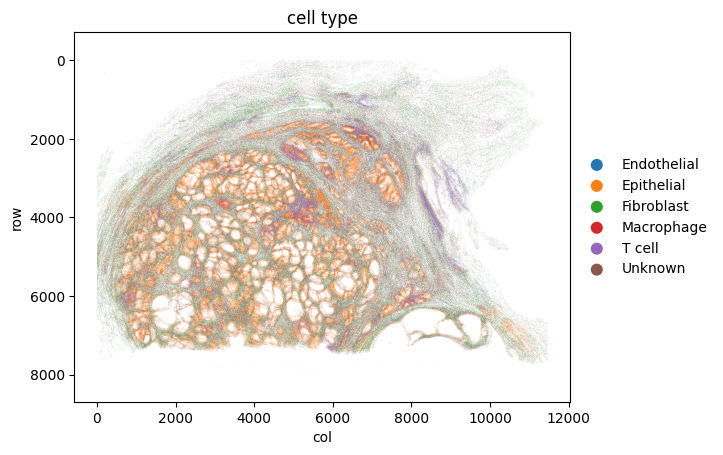

S18-9906 (1017529, 24)
S18-9906-U3
S18-9906-U10
S18-9906-U18
S18-9906-U25
dict_keys(['S18-9906-U3', 'S18-9906-U10', 'S18-9906-U18', 'S18-9906-U25'])


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


S18-9906-U10 (276402, 24)


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_146382/3959162083.py:44: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f.obs['row'] = warped[:, 0]
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


S18-9906-U18 (233259, 24)


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_146382/3959162083.py:44: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f.obs['row'] = warped[:, 0]
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


S18-9906-U25 (241401, 24)


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_146382/3959162083.py:44: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f.obs['row'] = warped[:, 0]
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


S18-9906-U3 (266467, 24)


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_146382/3959162083.py:44: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f.obs['row'] = warped[:, 0]
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/merge.py:217: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(dtype):
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:315: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

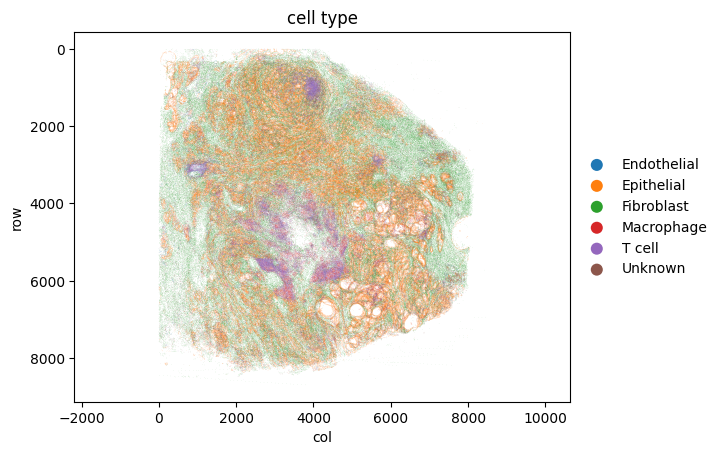

In [92]:
out_dir = project_dir / 'codex'
out_dir.mkdir(parents=True, exist_ok=True)

for fp in fps[:]:
    case = fp.split('/')[-1].replace('_cell_typed.h5ad', '')
    adata = sc.read_h5ad(fp)
    config = yaml.safe_load(open(project_dir / case / 'registered' / 'metadata.yaml'))
    print(case, adata.shape)
    
    target_sid = config['target_sid']

    sid_to_ddf = {}

    for idx, item in enumerate(config['sections']):
        sid = item['sid']
        mapping = item['data'][0]
        dtype, filepath = mapping['dtype'], mapping['filepath']
        scale = .2

        if sid != target_sid and 'multiplex' in dtype: # initial registration target section will not have ddf
            print(sid)
            ddf_fp = list(utils.listfiles(project_dir / case / 'registration', regex=sid + r'_ddf.tif$'))[0]

            assert os.path.exists(ddf_fp), f'Expected a warp field file at {ddf_fp}, but no file was found.'
            ddf = bigwarp.read_bigwarp_warp_field(ddf_fp, scale) # ddfs are (c h w)
            sid_to_ddf[sid] = ddf
    print(sid_to_ddf.keys())

    stacked = []
    sids = sorted(set(adata.obs['sid']))
    
    exclude = ['S18-5591-U2', 'S18-5591-U6']
    sids = [x for x in sids if x not in exclude]
    
    for sid in sids:
        f = adata[adata.obs['sid']==sid]
        print(sid, f.shape)
        corrected_sid = remap_sid(sid)

        ddf = sid_to_ddf[corrected_sid]

        warped, mask = bigwarp.warp_pts_fast(f.obs[['row', 'col']].values.astype(int), ddf)
        f = f[mask]
        f.obs['row'] = warped[:, 0]
        f.obs['col'] = warped[:, 1]

        stacked.append(f)

    new = anndata.concat(stacked)
    new.obs['sid'] = [remap_sid(x) for x in new.obs['sid']]
    
    if case in case_to_downscale:
        new.obs['row'] *= case_to_downscale[case]
        new.obs['col'] *= case_to_downscale[case]
    
    fig, ax = plt.subplots()
    sc.pl.scatter(new, x='col', y='row', color='cell_type', ax=ax, show=False)
    ax.axis('equal')
    ax.invert_yaxis()
    plt.show()

    new.write_h5ad(out_dir / f'{case}_cell_typed.h5ad')